In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "../00_setup.py").load_module()

# Stellargraph - Binary Classification - Tests

Testing a simple binary model in stellargraph.  Trying some different approaches.  This is much like the code in 02_sg_cora_binary_model.ipynb, but with model creation in a function so I can vary some parameters.

Based on the code in 
https://stellargraph.readthedocs.io/en/stable/demos/node-classification/graphsage-node-classification.html 

Also see 01_stellargraph_vignette.ipynb in this folder!

If I were doing actual hyperparameter tuning I'd need an unseen data split to validate a "final" model but here I'm just playing to get a general idea of behavior

*This script takes about 1 hour on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
import time
import datetime

In [4]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

2023-11-29 22:22:29.843858: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-29 22:22:29.843879: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-29 22:22:29.843886: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-29 22:22:29.843919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-29 22:22:29.843935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [6]:
import tensorflow.keras.metrics as km
from keras import initializers

## Functions for some plots commonly used

In [7]:
def metric_plot(data, metric_name = 'auc',
               x_name = 'learning_rate'):
    fig, ax = plt.subplots(figsize = (6, 3))
    data.reset_index(level=0) \
        [['level_0', x_name, metric_name]] \
        .pivot(index=x_name, columns='level_0') \
        .plot(legend=None, marker='o', ax=ax)
    ax.set_ylabel(metric_name)
    ax.set_title(f'{x_name} - {metric_name} effects')
    return fig

In [8]:
def history_plot(data, metric_name = 'auc',
               x_name = 'learning_rate'):
    fig, ax = plt.subplots(figsize = (4, 3))
    
    if metric_name.startswith('val_'):
        base_met = metric_name.split('val_')[1]
        dset = 'test'
    else:
        base_met = metric_name
        dset = 'train'

    data[[metric_name, x_name]] \
        .pivot(columns=x_name) \
        .plot(figsize = (4, 3), label=None, ax=ax)
    ax.set_xlabel('epochs')
    ax.set_ylabel(base_met)

    
    ax.set_title(f'{base_met} - {dset} progress curves')
    ax.legend(title=x_name)

## Import data, get binary labels 
Instead of multiclass topics, do "neural network or not?" model

In [9]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [10]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [11]:
# Get a target which indicates whether the subject is or is not neural networks

In [12]:
node_subjects.value_counts()

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64

In [13]:
node_is_nn = pd.Series(np.where(node_subjects == 'Neural_Networks', 1, 0).astype('int'),
                      index=node_subjects.index)

In [14]:
node_is_nn.value_counts()

0    1890
1     818
Name: count, dtype: int64

In [15]:
node_is_nn.value_counts(normalize=True)

0    0.697932
1    0.302068
Name: proportion, dtype: float64

In [16]:
# Keep the small train fraction as you don't need more, and I want
# quicker results since I am trying scenarios
train_subjects, test_subjects = model_selection.train_test_split(
    node_is_nn.index, train_size=0.1, test_size=None, stratify=node_is_nn
)

In [17]:
train_targets = node_is_nn[train_subjects]
test_targets = node_is_nn[test_subjects]

In [18]:
#Added to vignette
np.random.seed(16)
tf.random.set_seed(16)

## Quick look at the features
It looks like many are binary, with low means/

In [19]:
pd.DataFrame(G.node_features()).describe()

,0,1,2,3,4,5,6,7,8,9,...,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
count,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,...,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000
mean,0.005908,0.012186,0.025849,0.026588,0.060931,0.002585,0.010709,0.002954,0.011817,0.002216,...,0.040620,0.026219,0.017356,0.042097,0.010340,0.001108,0.012555,0.002216,0.024003,0.004431
std,0.076653,0.109736,0.158715,0.160905,0.239247,0.050786,0.102948,0.054282,0.108081,0.047027,...,0.197446,0.159814,0.130618,0.200849,0.101176,0.033272,0.111366,0.047027,0.153086,0.066433
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
pd.DataFrame(G.node_features()).iloc[0, :].value_counts(dropna=False)

0
0.0    1413
1.0      20
Name: count, dtype: int64

In [21]:
pd.DataFrame(G.node_features()).iloc[100, :].value_counts(dropna=False)

100
0.0    1408
1.0      25
Name: count, dtype: int64

## Function to build and evaluate a model

See also https://stackoverflow.com/questions/57120261/how-to-get-rid-of-the-n-for-keras-metric-names

In [22]:
def do_model(G = G,
             train_targets = train_targets,
             test_targets = test_targets,
             batch_size = 50,
             num_samples = [10, 5],
             layer_sizes=[32, 32],
             dropout = 0.5,
             aggregator = None,
             epochs = 20,
            learning_rate = 0.005):
    
    tf.keras.backend.clear_session()
    
    generator = GraphSAGENodeGenerator(G, batch_size, num_samples, seed=121)
    train_gen = generator.flow(train_targets.index, train_targets, shuffle=True)
    graphsage_model = GraphSAGE(layer_sizes = layer_sizes,
                                generator=generator, 
                                bias=True, 
                                dropout=dropout,
                               aggregator = aggregator,
                               kernel_initializer=initializers.glorot_uniform(seed=133))
    x_inp, x_out = graphsage_model.in_out_tensors()
    prediction = layers.Dense(units=1, activation="sigmoid",
                         kernel_initializer=initializers.glorot_uniform(seed=85))(x_out)
    
    model = Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
        loss = losses.binary_crossentropy, 
        metrics=["acc", km.AUC(name='auc'), km.Precision(name='precision'), 
                 km.Recall(name='recall')])
        
    test_gen = generator.flow(test_targets.index, test_targets)
    
    history = model.fit(train_gen, epochs=epochs, validation_data=test_gen, 
                        verbose=0, shuffle=False)
    
    # Save history in a data frame
    history_df = pd.DataFrame(history.history)
        
    # Evaluate metrics
    test_metrics = model.evaluate(test_gen)
    train_metrics = model.evaluate(train_gen)
    
    metrics_df = pd.concat([pd.DataFrame(dict(zip(model.metrics_names, 
                                                  [[t] for t in train_metrics]))),
                         pd.DataFrame(dict(zip(model.metrics_names, 
                                               [[t] for t in test_metrics])))],
                        keys=['train', 'test'])
    
    return metrics_df, history_df

In [23]:
# Look at defaults
metrics_def, history_def = do_model()

2023-11-29 22:22:32.256023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:22:33.640680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 45ms/step - loss: 0.0282 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


In [24]:
metrics_def

,,loss,acc,auc,precision,recall
train,0,0.028245,1.00000,1.000000,1.000000,1.000000
test,0,0.297277,0.90443,0.943276,0.835781,0.850543


In [25]:
history_def.tail(3)

,loss,acc,auc,precision,recall,val_loss,val_acc,val_auc,val_precision,val_recall
17,0.040785,1.000000,1.0,1.000000,1.000000,0.303376,0.901559,0.937897,0.861516,0.802989
18,0.041893,0.996296,1.0,0.987952,1.000000,0.306892,0.900328,0.944705,0.860908,0.798913
19,0.046440,0.996296,1.0,1.000000,0.987805,0.295794,0.904840,0.945256,0.835106,0.853261


## Modify learning rates
The model fits in just a couple epochs and overfits, so look at slower rates

In [26]:
test_rates = [0.0005, 0.001, 0.002]

In [27]:
def do_rates(learning_rate = 0.005):
    this_metrics, this_history = do_model(learning_rate = learning_rate)
    
    this_metrics['learning_rate'] = learning_rate
    this_history['learning_rate'] = learning_rate
    return this_metrics, this_history

In [28]:
lr_metrics = pd.DataFrame()
lr_history = pd.DataFrame()
for learning_rate in test_rates:
    this_metrics, this_history = do_rates(learning_rate)
    lr_metrics = pd.concat([lr_metrics, this_metrics])
    lr_history = pd.concat([lr_history, this_history])

2023-11-29 22:22:52.926168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:22:54.191206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 45ms/step - loss: 0.2408 - acc: 0.9778 - auc: 0.9979 - precision: 0.9634 - recall: 0.9634


2023-11-29 22:23:13.443295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:23:14.811150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 50ms/step - loss: 0.1514 - acc: 0.9889 - auc: 0.9997 - precision: 0.9759 - recall: 0.9878


2023-11-29 22:23:34.307839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:23:35.845878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 54ms/step - loss: 0.0831 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


In [29]:
# Append the default rate to the frames 
lr_metrics = lr_metrics[lr_metrics['learning_rate'].isin(test_rates)]
metrics_def['learning_rate'] = 0.005
lr_metrics = pd.concat([lr_metrics, metrics_def])

In [30]:
 lr_metrics[lr_metrics['learning_rate'].isin(test_rates)]

,,loss,acc,auc,precision,recall,learning_rate
train,0,0.240800,0.977778,0.997892,0.963415,0.963415,0.0005
test,0,0.347499,0.898277,0.948134,0.881250,0.766304,0.0005
train,0,0.151360,0.988889,0.999740,0.975904,0.987805,0.0010
test,0,0.287881,0.913043,0.952556,0.881924,0.822011,0.0010
train,0,0.083088,1.000000,1.000000,1.000000,1.000000,0.0020
test,0,0.271488,0.907301,0.951602,0.852210,0.838315,0.0020


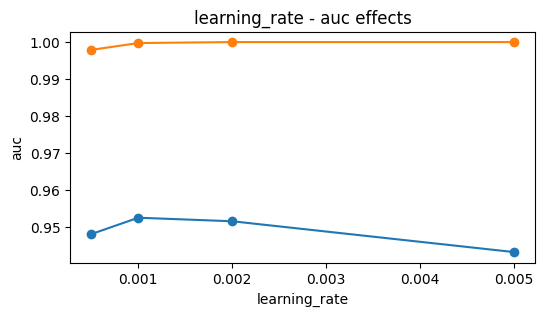

In [31]:
f = metric_plot(lr_metrics)

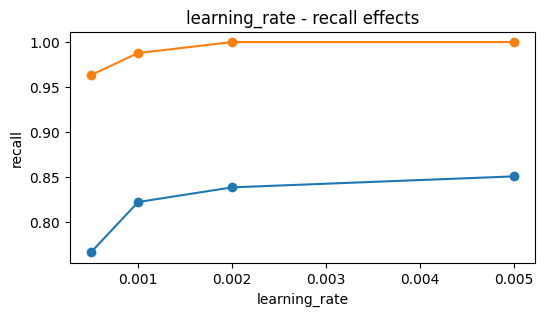

In [32]:
f = metric_plot(lr_metrics, 'recall')

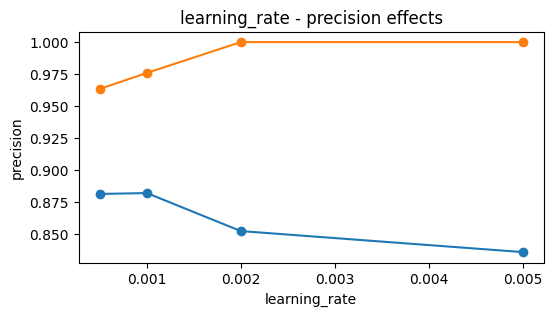

In [33]:
f = metric_plot(lr_metrics, 'precision')

It looks like overfitting is worse at higher learning rates.  Let's look at the history briefly

In [34]:
lr_history_copy = lr_history.copy()

In [35]:
# Append the default history to the learning rate run
history_def['learning_rate'] = 0.005
lr_history = lr_history[lr_history['learning_rate'].isin(test_rates)]
lr_history = pd.concat([lr_history, history_def])

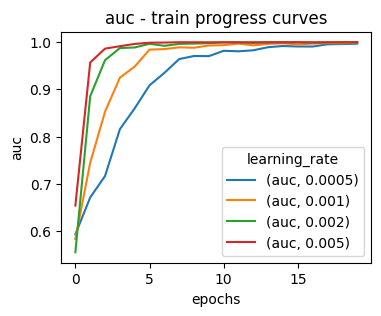

In [36]:
# Plot the test AUC fit progress
history_plot(lr_history)

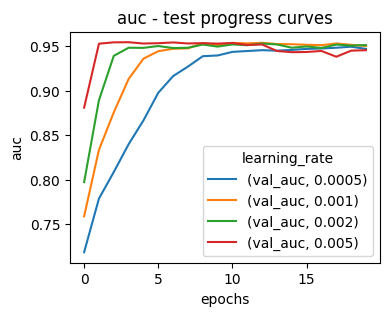

In [37]:
history_plot(lr_history, 'val_auc')

Definitely overfitting at higher learning rates!  Either fewer epochs or lower rates are better  The 0.005 learning rate seems especially problematic

## Changing layers?

I will use a smaller learning rate given the results above, and change the number of layers used in the GNN

In [38]:
def do_layers(layer_num = 2,
             learning_rate = 0.001):
    
    # Use more samples for the first layer, as in the vignette
    # Make the subsequent samples the same
    this_num_samples = [10] + [5]*(layer_num-1)
    this_layer_sizes = [32]*(layer_num)
    
    start_time = time.time() 
    this_metrics, this_history = do_model(num_samples = this_num_samples,
                              layer_sizes  = this_layer_sizes,
                              learning_rate = learning_rate)
    tot_time = time.time() - start_time
    
    this_metrics['layer_num'] = layer_num
    this_metrics['time'] = tot_time
    this_history['layer_num'] = layer_num
    return this_metrics, this_history

In [39]:
num_layers = [1, 2, 3, 4]

In [40]:
ly_metrics = pd.DataFrame()
ly_history = pd.DataFrame()
for ln in num_layers:
    this_metrics, this_history = do_layers(ln)
    ly_metrics = pd.concat([ly_metrics, this_metrics])
    ly_history = pd.concat([ly_history, this_history])

2023-11-29 22:23:56.405403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:23:57.606283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 47ms/step - loss: 0.1497 - acc: 0.9963 - auc: 1.0000 - precision: 0.9880 - recall: 1.0000


2023-11-29 22:24:13.259981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:24:14.919917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 54ms/step - loss: 0.1452 - acc: 0.9926 - auc: 0.9999 - precision: 0.9878 - recall: 0.9878


2023-11-29 22:24:35.468652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:24:38.210339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 79ms/step - loss: 0.1574 - acc: 0.9889 - auc: 0.9946 - precision: 0.9759 - recall: 0.9878


2023-11-29 22:25:56.472674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:26:00.450010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 247ms/step - loss: 0.1671 - acc: 0.9778 - auc: 0.9986 - precision: 1.0000 - recall: 0.9268


In [41]:
ly_metrics

,,loss,acc,auc,precision,recall,layer_num,time
train,0,0.149687,0.996296,1.000000,0.987952,1.000000,1,16.584881
test,0,0.349862,0.877769,0.939212,0.886926,0.682065,1,16.584881
train,0,0.145219,0.992593,0.999870,0.987805,0.987805,2,21.838553
test,0,0.287569,0.913043,0.950671,0.885294,0.817935,2,21.838553
train,0,0.157384,0.988889,0.994584,0.975904,0.987805,3,80.752822
test,0,0.295043,0.906481,0.936566,0.847945,0.841033,3,80.752822
train,0,0.167084,0.977778,0.998638,1.000000,0.926829,4,1213.214583
test,0,0.297459,0.905660,0.930588,0.869883,0.808424,4,1213.214583


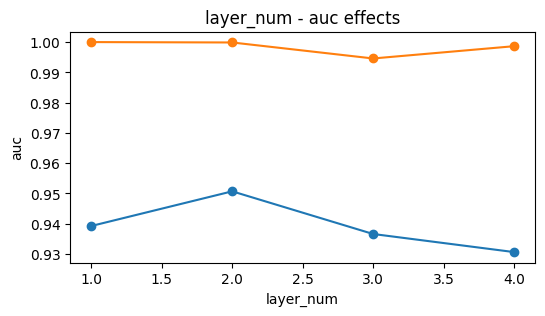

In [42]:
f = metric_plot(ly_metrics, 'auc', 'layer_num')

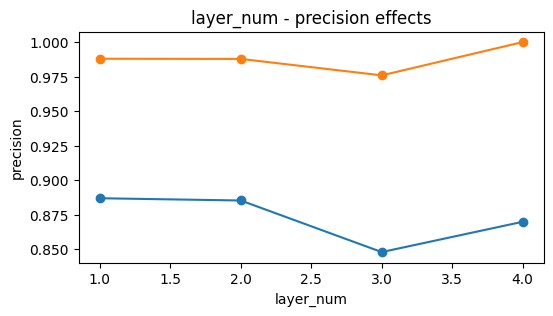

In [43]:
f = metric_plot(ly_metrics, 'precision', 'layer_num')

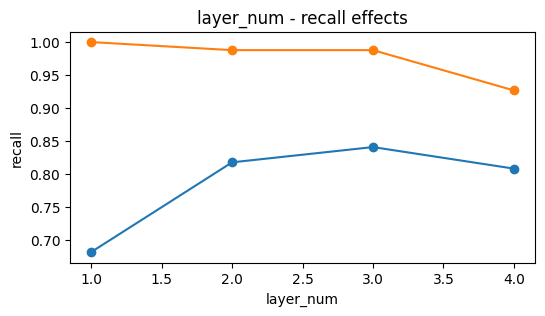

In [44]:
f = metric_plot(ly_metrics, 'recall', 'layer_num')

(0.0, 1273.0460680246354)

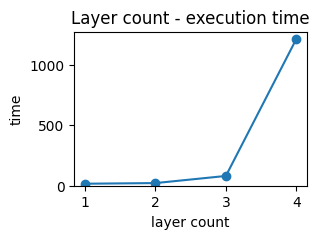

In [45]:
# Plot time
time_df = ly_metrics\
    [['layer_num', 'time']] \
    .drop_duplicates() \
    .plot(x='layer_num', y='time', legend=None, marker='o', figsize=(3,2))
plt.gca().set_xlabel('layer count')
plt.gca().set_ylabel('time')
plt.gca().set_title('Layer count - execution time')
plt.gca().set_ylim(bottom=0)

Execution time goes up sharply as layers increase

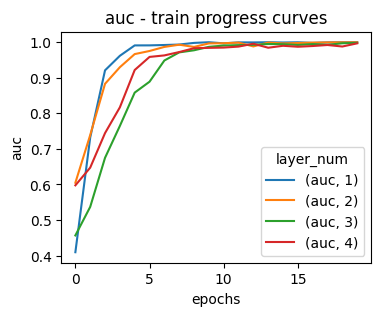

In [46]:
f = history_plot(ly_history, 'auc', 'layer_num')

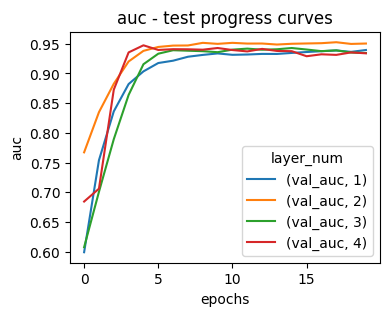

In [47]:
f = history_plot(ly_history, 'val_auc', 'layer_num')

Interestingly, morr layers doesn't seem better for this example. It seems to overfit possibly.  This dataset is prone to overfitting?

## Number of Samples

In [48]:
def do_samples(num_samp_base = 5,
               layer_num = 2,
             learning_rate = 0.001):
    
    # Use more samples for the first layer, as in the vignette
    # Make the subsequent samples the same
    this_num_samples = [num_samp_base*2] + [num_samp_base]*(layer_num-1)
    this_layer_sizes = [32]*(layer_num)
    
    start_time = time.time()
    this_metrics, this_history = do_model(num_samples = this_num_samples,
                              layer_sizes  = this_layer_sizes,
                              learning_rate = learning_rate)
    tot_time = time.time() - start_time
    
    this_metrics['num_samp'] = num_samp_base
    this_metrics['time'] = tot_time
    this_history['num_samp'] = num_samp_base
    return this_metrics, this_history

In [49]:
num_samps = [5, 10, 20]

In [50]:
ns_metrics = pd.DataFrame()
ns_history = pd.DataFrame()
for n in num_samps:
    this_metrics, this_history = do_samples(n)
    ns_metrics = pd.concat([ns_metrics, this_metrics])
    ns_history = pd.concat([ns_history, this_history])

2023-11-29 22:46:09.511183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:46:11.017343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 48ms/step - loss: 0.1489 - acc: 0.9926 - auc: 0.9996 - precision: 0.9762 - recall: 1.0000


2023-11-29 22:46:27.027375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:46:28.615017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 60ms/step - loss: 0.1393 - acc: 0.9926 - auc: 1.0000 - precision: 0.9762 - recall: 1.0000


2023-11-29 22:47:00.403050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:47:02.342411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 103ms/step - loss: 0.1377 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


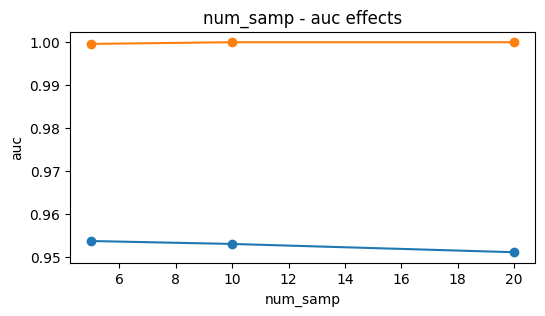

In [51]:
# Plot AUC
f = metric_plot(ns_metrics, 'auc', 'num_samp')

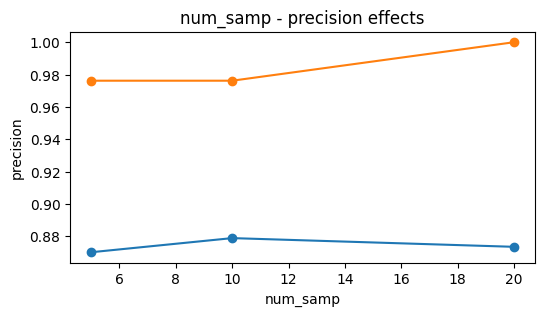

In [52]:
f = metric_plot(ns_metrics, 'precision', 'num_samp')

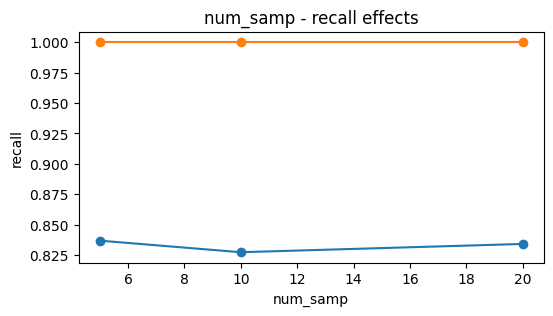

In [53]:
f = metric_plot(ns_metrics, 'recall', 'num_samp')

(0.0, 110.55059138536453)

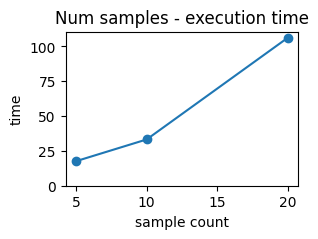

In [54]:
# Plot time
time_df = ns_metrics\
    [['num_samp', 'time']] \
    .drop_duplicates() \
    .plot(x='num_samp', y='time', legend=None, marker='o', figsize=(3,2))
plt.gca().set_xlabel('sample count')
plt.gca().set_ylabel('time')
plt.gca().set_title('Num samples - execution time')
plt.gca().set_ylim(bottom=0)

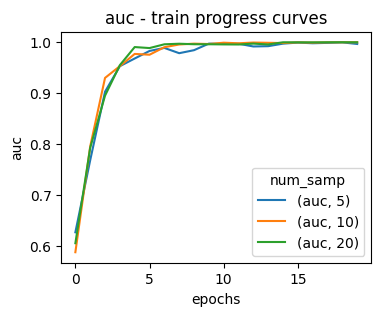

In [55]:
f = history_plot(ns_history, 'auc', 'num_samp')

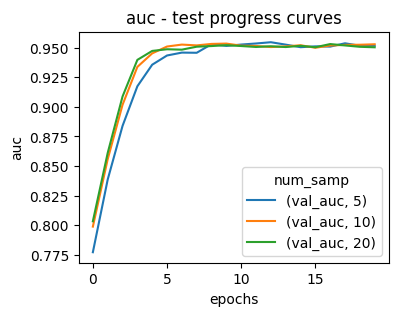

In [56]:
f = history_plot(ns_history, 'val_auc', 'num_samp')

Increasing samples doesn't seem to cause overfitting.  The models seem to get to the same place. More samples may increase speed of fit (very slight)

## Dropout
See what happens when dropout is modified.  Try a somewhat longer learning rate to consider overfitting

In [57]:
def do_dropout(dropout = 0.5,
               layer_num = 2,
             learning_rate = 0.005):
    
    # Use more samples for the first layer, as in the vignette
    # Make the subsequent samples the same
    this_num_samples = [10] + [5]*(layer_num-1)
    this_layer_sizes = [32]*(layer_num)
    
    start_time = time.time()
    this_metrics, this_history = do_model(num_samples = this_num_samples,
                                          layer_sizes  = this_layer_sizes,
                                          learning_rate = learning_rate,
                                         dropout = dropout)
    tot_time = time.time() - start_time
    
    this_metrics['dropout'] = dropout
    this_metrics['time'] = tot_time
    return this_metrics, this_history

In [58]:
dropouts = [0, 0.3, 0.5, 0.8, 0.9, 0.95]

In [59]:
d_metrics = pd.DataFrame()
d_history = pd.DataFrame()
for d in dropouts:
    this_metrics, this_history = do_dropout(d)
    d_metrics = pd.concat([d_metrics, this_metrics])
    d_history = pd.concat([d_history, this_history])

2023-11-29 22:48:46.838483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:48:48.384990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 50ms/step - loss: 0.0282 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


2023-11-29 22:49:03.556566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:49:05.178508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 50ms/step - loss: 0.0282 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


2023-11-29 22:49:21.176954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:49:22.774089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 66ms/step - loss: 0.0283 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


2023-11-29 22:49:39.714749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:49:41.737196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 66ms/step - loss: 0.0487 - acc: 0.9963 - auc: 0.9987 - precision: 0.9880 - recall: 1.0000


2023-11-29 22:49:58.833276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:50:00.845423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 62ms/step - loss: 0.0866 - acc: 0.9852 - auc: 0.9981 - precision: 0.9756 - recall: 0.9756


2023-11-29 22:50:18.360682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-29 22:50:20.486870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 65ms/step - loss: 0.3042 - acc: 0.8852 - auc: 0.9840 - precision: 0.9636 - recall: 0.6463


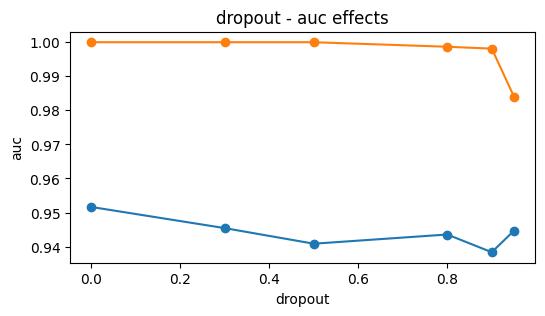

In [60]:
# Plot AUC
f = metric_plot(d_metrics, 'auc', 'dropout')

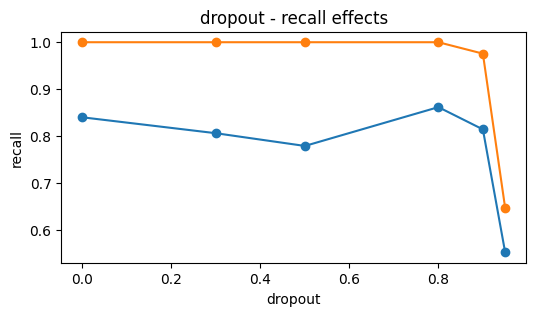

In [61]:
f = metric_plot(d_metrics, 'recall', 'dropout')

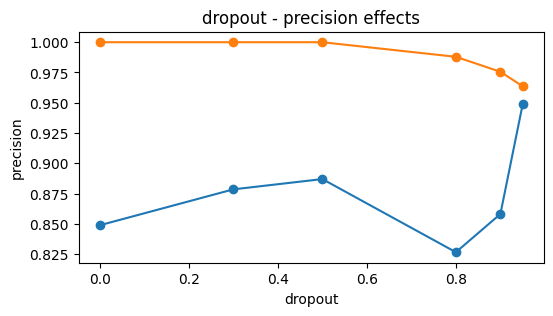

In [62]:
f = metric_plot(d_metrics, 'precision', 'dropout')

(0.0, 19.66507532596588)

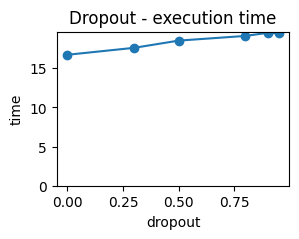

In [63]:
# Plot time
time_df = d_metrics\
    [['dropout', 'time']] \
    .drop_duplicates() \
    .plot(x='dropout', y='time', legend=None, marker='o', figsize=(3,2))
plt.gca().set_xlabel('dropout')
plt.gca().set_ylabel('time')
plt.gca().set_title('Dropout - execution time')
plt.gca().set_ylim(bottom=0)

KeyError: "['dropout'] not in index"

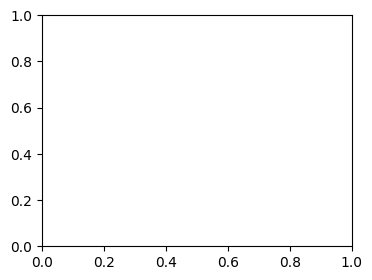

In [64]:
f = history_plot(d_history, 'auc', 'dropout')

In [ ]:
f = history_plot(d_history, 'val_auc', 'dropout')

Increasing dropout does seem to help with overfitting.  More epochs may be useful for train but not test at very high dropout?

## Hidden Layer Embedding Size
See what happens when dropout is modified.  Try a somewhat longer learning rate to consider overfitting

In [ ]:
def do_hidden_size(hidden_size = 32,
                   layer_num = 2,
                   learning_rate = 0.001):
    
    # Use more samples for the first layer, as in the vignette
    # Make the subsequent samples the same
    this_num_samples = [10] + [5]*(layer_num-1)
    this_layer_sizes = [hidden_size]*(layer_num)
    
    start_time = time.time()
    this_metrics, this_history = do_model(num_samples = this_num_samples,
                                          layer_sizes  = this_layer_sizes,
                                          learning_rate = learning_rate)
    tot_time = time.time() - start_time
    
    this_metrics['hidden_size'] = hidden_size
    this_metrics['time'] = tot_time
    this_history['hidden_size'] = hidden_size
    return this_metrics, this_history

In [ ]:
hl_sizes = [8, 16, 32, 64]

In [ ]:
hl_metrics = pd.DataFrame()
hl_history = pd.DataFrame()
for hl in hl_sizes:
    this_metrics, this_history = do_hidden_size(hl)
    hl_metrics = pd.concat([hl_metrics, this_metrics])
    hl_history = pd.concat([hl_history, this_history])

In [ ]:
# Plot AUC
f = metric_plot(hl_metrics, 'auc', 'hidden_size')

In [ ]:
hl_metrics

In [ ]:
f = metric_plot(hl_metrics, 'recall', 'hidden_size')

In [ ]:
f = metric_plot(hl_metrics, 'precision', 'hidden_size')

In [ ]:
# Plot time
time_df = hl_metrics\
    [['hidden_size', 'time']] \
    .drop_duplicates() \
    .plot(x='hidden_size', y='time', legend=None, marker='o', figsize=(3,2))
plt.gca().set_xlabel('hidden layer dimension')
plt.gca().set_ylabel('time')
plt.gca().set_title('Hidden layers - execution time')
plt.gca().set_ylim(bottom=0)

In [ ]:
f = history_plot(hl_history, 'auc', 'hidden_size')

In [ ]:
f = history_plot(hl_history, 'val_auc', 'hidden_size')

Increasing the size of the hidden layer seems to increase performance, without affecting overfitting. Some of this may just be speed, and maybe 8 layers would get to the same performance in more epochs.   Above ~16 features performance improvement is modest (I don't check larger numbers).  Given that you might use fewer epochs to train a model, a larger hidden dimension may actually decrease overall fit time!